# Machine Learning Pipeline - Interpretation

Check the python kernel we are using, should be the local one, not the one in the virtual environment

In [21]:
import sys
print(sys.executable)

/usr/bin/python3


## Import libraries

In [22]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import math
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Variables

In [23]:
%store -r X_train_reduced
%store -r X_test_reduced
%store -r y_train
%store -r y_test
%store -r bin_train
%store -r bin_test
%store -r model_fs

In [24]:
bin_train = bin_train.squeeze()


In [25]:
y_train = pd.Series(y_train)

In [26]:
predictions_array = model_fs.predict(X_train_reduced)
predictions_array = pd.Series(predictions_array, index = bin_train.index)

In [27]:
deltas = np.abs(y_train - predictions_array).astype(float)

In [28]:
rownames = ["bin", "observed", "predicted", "residual"]

In [29]:
errors_df = pd.DataFrame([bin_train, y_train, predictions_array, deltas], index = rownames).transpose()
errors_df["idx"] = errors_df.index; errors_df = errors_df.astype({"residual":float})

## Feature Interpretation

In [30]:
backbone = pd.read_csv(filepath_or_buffer= "/home/ieo7429/Desktop/THESIS_GAB/tables/backbone_1Mbp.tsv", sep = "\t", header = 0)

In [31]:
errors_df_with_coords = pd.merge(left = backbone, right = errors_df, how = "inner", on = "bin")

In [32]:
top10_worst_predictions = errors_df_with_coords.nlargest(10, "residual")

In [33]:
top10_worst_predictions

,chr,start,end,bin,observed,predicted,residual,idx
659,chr7,67058425,68059296,7_68,-0.602085,0.278835,0.880921,1789
1324,chr19,22048093,23050278,19_23,-1.189417,-0.571174,0.618243,834
601,chr6,113075937,114076608,6_114,-0.619971,-0.003616,0.616355,1627
1106,chr14,43140439,44143704,14_44,1.401349,0.787156,0.614193,544
321,chr3,95010736,96010848,3_96,1.45156,0.852501,0.599059,1328
206,chr2,145118901,146119720,2_146,0.604568,0.012259,0.592308,910
656,chr7,53046217,54047088,7_54,1.244956,0.681872,0.563084,1783
595,chr6,85057121,86057792,6_86,0.540286,-0.007091,0.547377,1689
493,chr5,15076261,16081344,5_16,1.146527,0.615718,0.530809,1546
693,chr7,118102897,119103768,7_119,1.2666,0.755849,0.510751,1711


In [34]:
explainer = shap.TreeExplainer(model_fs, approximate= False)
shap_values = explainer(X_train_reduced)

In [35]:
original_idx = y_train.index.get_loc("544")

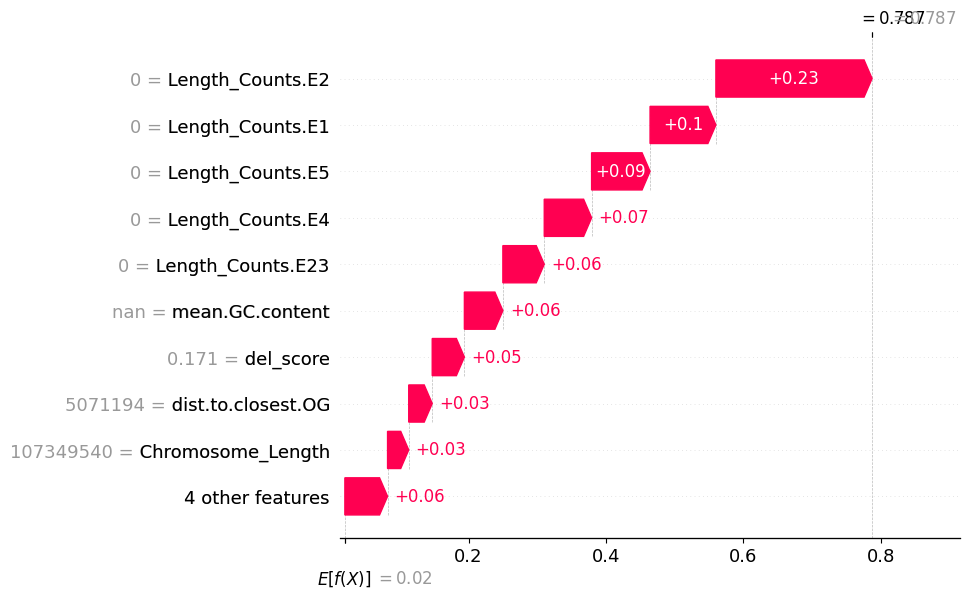

In [36]:
shap.plots.waterfall(shap_values[original_idx])

In [37]:
shap_vals_df = pd.DataFrame(shap_values.values, columns= X_train_reduced.columns)

In [38]:
cols_idxs = np.argmax(shap_vals_df, axis = 1)

In [39]:
cols_occurrences = pd.Series(X_train_reduced.columns[cols_idxs], index= bin_train.index, name= "annotation")

In [40]:
annot_with_bins = pd.concat([bin_train, cols_occurrences], axis = 1)

In [41]:
annot_with_coords = pd.merge(left = annot_with_bins, right = backbone, how = "inner", on = "bin")
annot_with_coords = pd.merge(left = annot_with_coords, right = errors_df[["bin","predicted"]], how = "inner", on = "bin")
annot_with_coords = annot_with_coords[["bin", "chr", "start", "end", "annotation", "predicted"]]

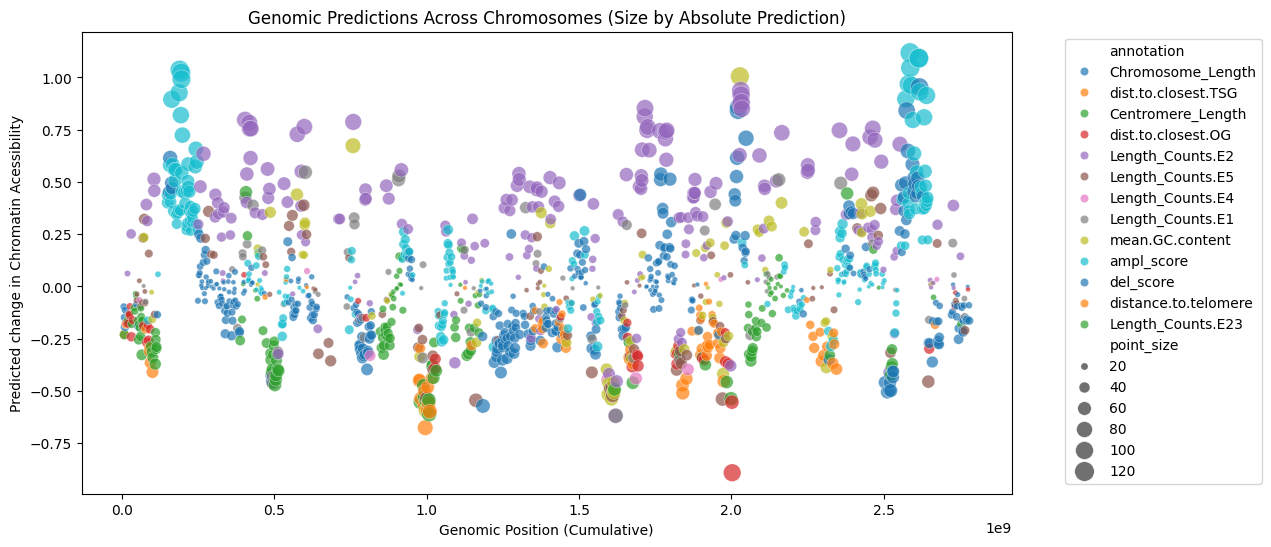

In [42]:
df = annot_with_coords

df["midpoint"] = (df["start"] + df["end"]) / 2

df.sort_values(["chr", "start"], inplace=True)

chr_offsets = {chrom: offset for chrom, offset in zip(df["chr"].unique(), np.cumsum([0] + list(df.groupby("chr")["end"].max()[:-1])))}
df["cumulative_midpoint"] = df["midpoint"] + df["chr"].map(chr_offsets)

df["point_size"] = (df["predicted"].abs() * 100) + 10

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="cumulative_midpoint",
    y="predicted",
    hue="annotation",
    size="point_size",
    sizes=(10, 200),
    palette="tab10",
    alpha=0.7
)

plt.xlabel("Genomic Position (Cumulative)")
plt.ylabel("Predicted change in Chromatin Acessibility")
plt.title("Genomic Predictions Across Chromosomes (Size by Absolute Prediction)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()